# 🩺 Football Injury Prediction — Notebook 04

## **Model Evaluation, Interpretation & Conclusions**

This notebook focuses on evaluating the trained injury‑risk models and translating their behavior into meaningful, actionable insights.

### **Objectives**

* Load the trained model, preprocessing pipeline, and test data
* Evaluate model performance (Accuracy, Precision, Recall, F1) with focus on **minimizing false negatives**
* Visualize confusion matrix and classification metrics
* Interpret model decisions using **feature importance** and **SHAP values**
* Identify key drivers of injury risk and explain their impact
* Produce clear, practical conclusions for coaches, sports scientists, and medical staff

This notebook closes the project by connecting model performance with real-world decision‑making.


## 1. Imports


In [117]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix


## 2. Load data


In [118]:
DATA_DIR = "../data"
ART_DIR = "../artifacts"

DATA_CSV = os.path.join(DATA_DIR, "data.csv")

df = pd.read_csv(DATA_CSV)
print("Loaded data:", df.shape)


Loaded data: (800, 19)


## 3. Load preprocessor


In [119]:
PREPROC_PATH = os.path.join(ART_DIR, "preprocessor.pkl")

preprocessor = joblib.load(PREPROC_PATH)
print("Loaded preprocessor.")


Loaded preprocessor.


## 4. Load model


In [120]:
MODEL_PATH = os.path.join(ART_DIR, "random_forest_model.pkl")

model = joblib.load(MODEL_PATH)
print("Loaded model.")


Loaded model.


## 5. Load feature lists


In [121]:
NUM_FEATURES_PATH = os.path.join(ART_DIR, "numeric_features.pkl")
CAT_FEATURES_PATH = os.path.join(ART_DIR, "categorical_features.pkl")

numeric_features = joblib.load(NUM_FEATURES_PATH)
categorical_features = joblib.load(CAT_FEATURES_PATH)

print("Numeric features loaded:", len(numeric_features))
print("Categorical features loaded:", len(categorical_features))


Numeric features loaded: 21
Categorical features loaded: 1


## 6. Recreate feature engineering


In [122]:
# Reapply engineered features exactly as in Notebook 02
df["Readiness_Strength"] = (
    df["Knee_Strength_Score"] +
    df["Hamstring_Flexibility"] +
    df["Balance_Test_Score"]
)

df["Workload_Index"] = (
    df["Training_Hours_Per_Week"] * 0.6 +
    df["Matches_Played_Past_Season"] * 0.4
)

df["Prep_Score"] = (
    df["Sleep_Hours_Per_Night"] * 0.4 +
    df["Warmup_Routine_Adherence"] * 0.4 +
    df["Nutrition_Quality_Score"] * 0.2
)

df["Injury_History_Weight"] = (
    df["Previous_Injury_Count"] * 0.7 +
    df["Stress_Level_Score"] * 0.3
)




## 7. Recreate test split


In [123]:
X = df.drop("Injury_Next_Season", axis=1)
y = df["Injury_Next_Season"]

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((600, 22), (200, 22))

## 8. Load pipeline and extract fitted preprocessor


In [124]:
MODEL_PATH = "../artifacts/random_forest_model.pkl"
FITTED_PREPROC_PATH = "../artifacts/preprocessor_fitted_from_pipeline.pkl"

if 'model' not in globals():
    if os.path.exists(MODEL_PATH):
        model = joblib.load(MODEL_PATH)
        print("Loaded model from", MODEL_PATH)
    else:
        raise FileNotFoundError(f"Model pipeline not found at {MODEL_PATH}")

# If model is a Pipeline, try to get the 'preprocess' step
preprocessor_fitted = None
if isinstance(model, Pipeline):
    steps = list(model.named_steps.keys())
    print("Pipeline steps:", steps)
    if "preprocess" in model.named_steps:
        preprocessor_fitted = model.named_steps["preprocess"]
        print("Extracted 'preprocess' step from pipeline (will use this as fitted preprocessor).")
    else:
        # try to find first ColumnTransformer-like step
        for name, step in model.named_steps.items():
            step_type = type(step).__name__.lower()
            if "columntransformer" in step_type or "transform" in step_type:
                preprocessor_fitted = step
                print(f"Extracted step '{name}' as preprocessor candidate.")
                break

if preprocessor_fitted is None:
    print("No preprocessor step found inside the pipeline. You may need to fit a preprocessor locally or re-run training notebook.")
else:
    # Optionally save the fitted preprocessor for reuse in Notebook 04
    joblib.dump(preprocessor_fitted, FITTED_PREPROC_PATH)
    print("Saved fitted preprocessor to", FITTED_PREPROC_PATH)


Pipeline steps: ['preprocess', 'model']
Extracted 'preprocess' step from pipeline (will use this as fitted preprocessor).
Saved fitted preprocessor to ../artifacts/preprocessor_fitted_from_pipeline.pkl


## 9. Transform X_test using the extracted fitted preprocessor


In [125]:
# Now transform X_test (X_test should already exist from step 7)
try:
    X_test_trans = preprocessor_fitted.transform(X_test)
except Exception as e:
    # fallback: try DataFrame wrapper (some transformers expect DataFrame input)
    try:
        X_test_trans = preprocessor_fitted.transform(pd.DataFrame(X_test))
    except Exception as e2:
        raise RuntimeError("Failed to transform X_test with extracted preprocessor: " + str(e2))

print("X_test_trans shape:", getattr(X_test_trans, "shape", None))


X_test_trans shape: (200, 24)


## 10. Evaluate model on test set (pipeline on raw X_test)


In [126]:
# Use the pipeline end-to-end on raw X_test (recommended, simpler)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None



## 11. Plot confusion matrix and save figure


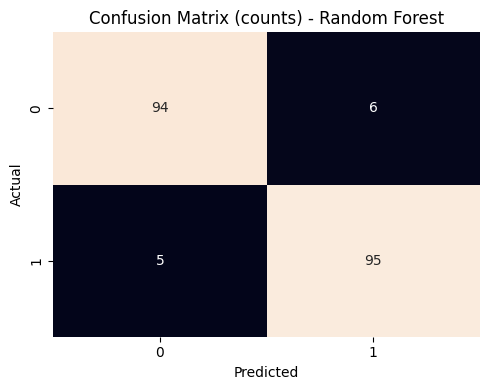

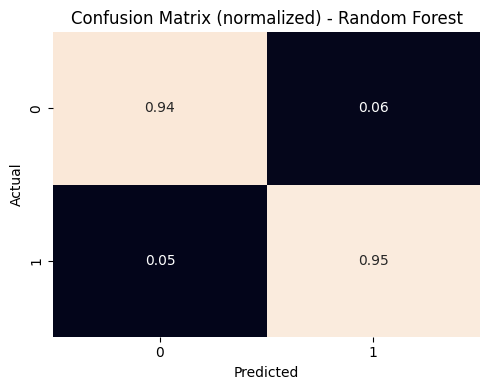

Saved confusion matrices to: ../artifacts/confusion_matrix_rf.png and ../artifacts/confusion_matrix_rf_normalized.png


In [127]:
# Plot confusion matrix (absolute counts) and save to ../data/

OUT_DIR = "../artifacts"
os.makedirs(OUT_DIR, exist_ok=True)
FIG_PATH = os.path.join(OUT_DIR, "confusion_matrix_rf.png")
FIG_PATH_NORM = os.path.join(OUT_DIR, "confusion_matrix_rf_normalized.png")

# Ensure y_test and y_pred exist
if 'y_test' not in globals() or 'y_pred' not in globals():
    raise RuntimeError("y_test or y_pred not found in memory. Run evaluation cell (## 10) first.")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, None]

# Plot absolute counts
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (counts) - Random Forest")
plt.tight_layout()
plt.savefig(FIG_PATH, dpi=150)
plt.show()

# Plot normalized matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (normalized) - Random Forest")
plt.tight_layout()
plt.savefig(FIG_PATH_NORM, dpi=150)
plt.show()

print("Saved confusion matrices to:", FIG_PATH, "and", FIG_PATH_NORM)


## 12. Feature importance (Random Forest) — global importance and save results


Saved feature importance CSV to: ../artifacts/feature_importance_rf.csv


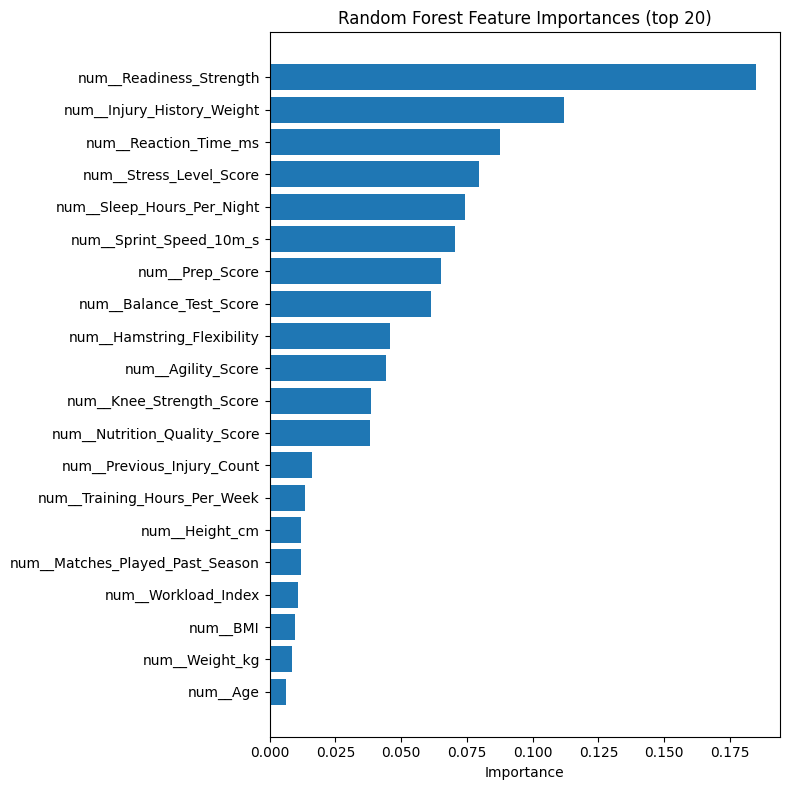

Saved importance figure to: ../artifacts/feature_importance_rf.png


In [128]:
# Compute feature importances from the Random Forest estimator and save plot + CSV
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

OUT_DIR = "../artifacts"
os.makedirs(OUT_DIR, exist_ok=True)
FIG_PATH = os.path.join(OUT_DIR, "feature_importance_rf.png")
CSV_PATH = os.path.join(OUT_DIR, "feature_importance_rf.csv")
PKL_PATH = os.path.join(OUT_DIR, "feature_importance_rf.pkl")

# Get estimator (the final model) from the pipeline
if hasattr(model, "named_steps"):
    estimator = model.named_steps.get("model", model.steps[-1][1])
else:
    estimator = model

# Ensure the estimator has feature_importances_
if not hasattr(estimator, "feature_importances_"):
    raise RuntimeError("The final estimator does not expose feature_importances_. Cannot compute RF importances.")

importances = estimator.feature_importances_

# Try to recover transformed feature names
feature_names = None
try:
    # prefer using a fitted preprocessor to get output names
    if 'preprocessor_fitted' in globals() and hasattr(preprocessor_fitted, "get_feature_names_out"):
        # if preprocessor expects input column names, pass X.columns
        try:
            # X (raw) should be available from earlier cells
            feature_names = preprocessor_fitted.get_feature_names_out(X.columns)
        except Exception:
            # fallback: call without args if supported
            feature_names = preprocessor_fitted.get_feature_names_out()
    else:
        # fallback: try to use numeric_features + categorical_features if available
        if 'numeric_features' in globals() and 'categorical_features' in globals():
            # Note: after ColumnTransformer/OneHot the number of output cols may differ, but this is a best-effort fallback
            feature_names = numeric_features + categorical_features
except Exception as e:
    print("Could not auto-detect feature names from preprocessor:", e)
    feature_names = None

# As a final fallback, create generic names
if feature_names is None or len(feature_names) != len(importances):
    feature_names = [f"f_{i}" for i in range(len(importances))]
    print("Using generic feature names due to mismatch in detected names and importances length.")

# Build DataFrame of importances
fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False).reset_index(drop=True)

# Save CSV + pickle
fi_df.to_csv(CSV_PATH, index=False)
joblib.dump(fi_df, PKL_PATH)
print("Saved feature importance CSV to:", CSV_PATH)

# Plot top 20 features
top_n = min(20, len(fi_df))
plt.figure(figsize=(8, 4 + top_n * 0.2))
plt.barh(fi_df["feature"].iloc[:top_n][::-1], fi_df["importance"].iloc[:top_n][::-1])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances (top {})".format(top_n))
plt.tight_layout()
plt.savefig(FIG_PATH, dpi=150)
plt.show()

print("Saved importance figure to:", FIG_PATH)

explainer = shap.TreeExplainer(estimator)
shap_values_raw = explainer.shap_values(X_test_trans)



## 13. SHAP — extract positive-class slice and produce plots

Selected vals = shap_values_raw[..., 1]; vals.shape = (200, 24)
Final feature_names length: 24
Feature names preview: ['num__Age', 'num__Height_cm', 'num__Weight_kg', 'num__Training_Hours_Per_Week', 'num__Matches_Played_Past_Season', 'num__Previous_Injury_Count', 'num__Knee_Strength_Score', 'num__Hamstring_Flexibility', 'num__Reaction_Time_ms', 'num__Balance_Test_Score', 'num__Sprint_Speed_10m_s', 'num__Agility_Score', 'num__Sleep_Hours_Per_Night', 'num__Stress_Level_Score', 'num__Nutrition_Quality_Score', 'num__Warmup_Routine_Adherence', 'num__BMI', 'num__Readiness_Strength', 'num__Workload_Index', 'num__Prep_Score']


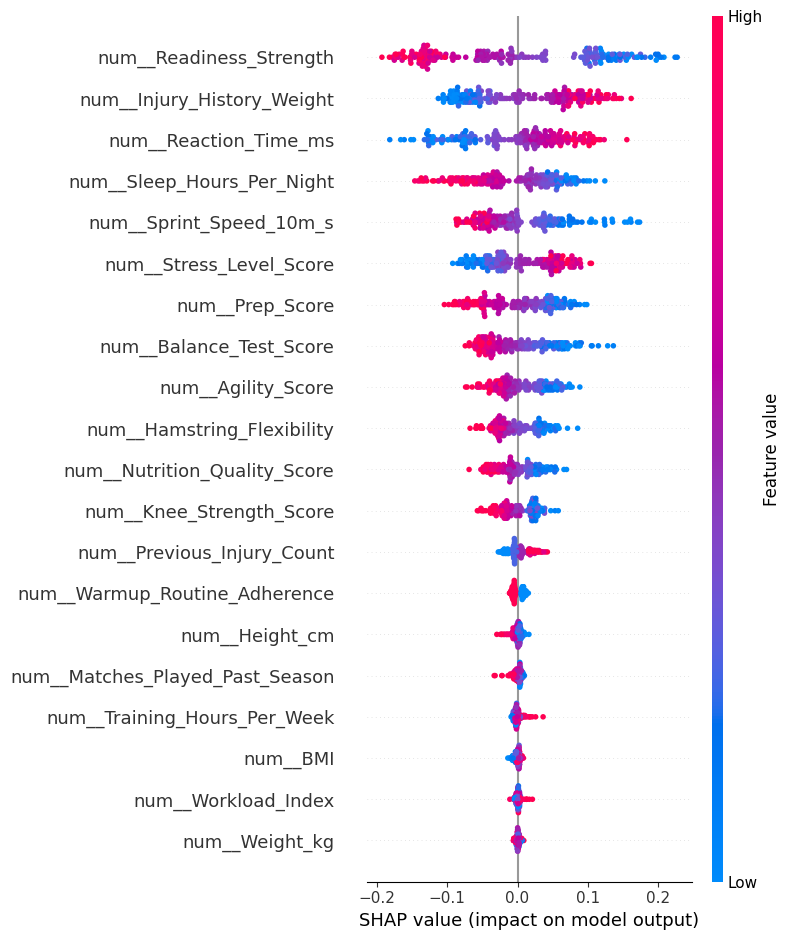

Saved SHAP summary to: ../artifacts/shap_summary_rf_fixed.png
Top SHAP feature: num__Readiness_Strength (index: 17 )


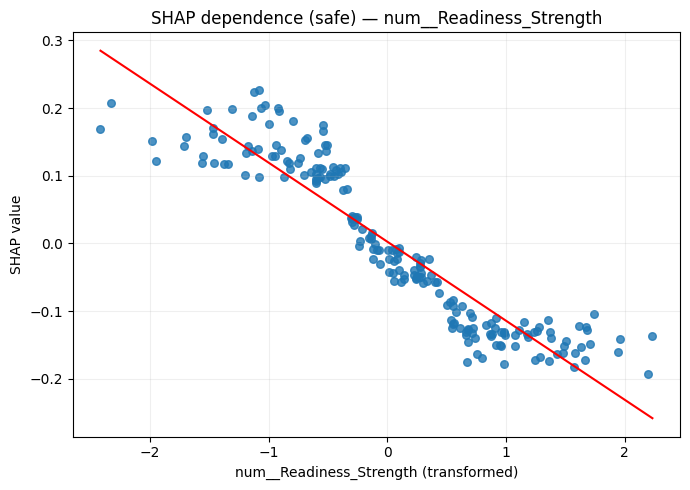

Saved SHAP dependence to: ../artifacts/shap_dependence_topfeature_rf_fixed.png
Selected sample index for waterfall: 64


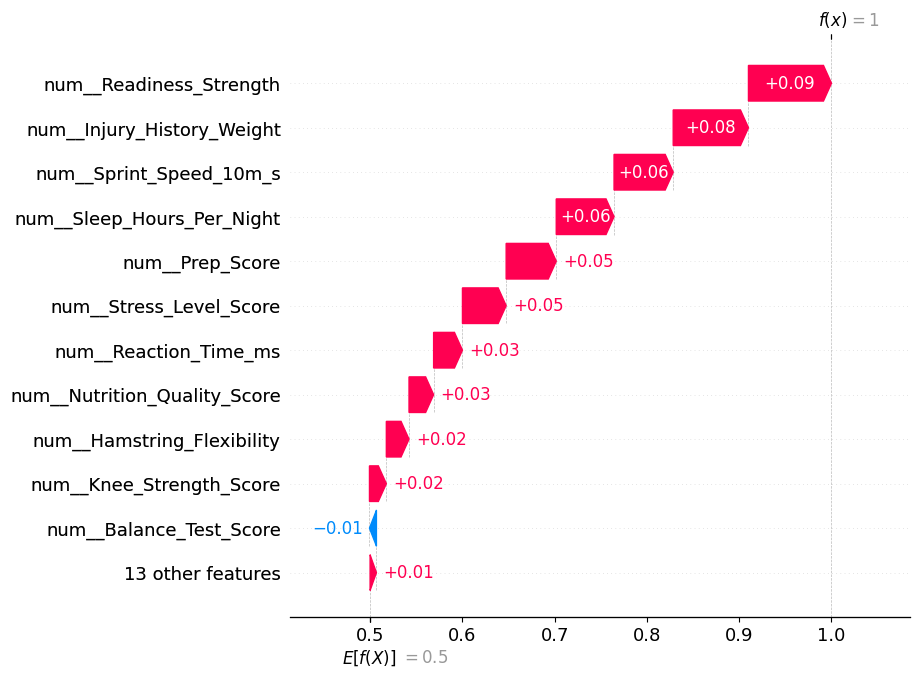

<Figure size 640x480 with 0 Axes>

Saved SHAP waterfall to: ../artifacts/shap_waterfall_example_rf_fixed.png
Saved SHAP CSV to: ../artifacts/shap_feature_importance_rf_fixed.csv


In [129]:
# This cell assumes shap_values_raw is already present (you ran explainer) and is shape (200,24,2).
# It selects class index 1 (positive), builds vals, aligns feature names and saves SHAP summary, dependence and waterfall.

OUT_DIR = "../artifacts"
os.makedirs(OUT_DIR, exist_ok=True)
SHAP_SUM_PATH = os.path.join(OUT_DIR, "shap_summary_rf_fixed.png")
SHAP_DEP_PATH = os.path.join(OUT_DIR, "shap_dependence_topfeature_rf_fixed.png")
SHAP_WATERFALL_PATH = os.path.join(OUT_DIR, "shap_waterfall_example_rf_fixed.png")
SHAP_CSV = os.path.join(OUT_DIR, "shap_feature_importance_rf_fixed.csv")
n_samples = X_test_trans.shape[0]
n_features_out = X_test_trans.shape[1]

# 1) If last axis is classes (as here), take class 1 (positive). If only 2 classes but last axis is 2 choose index 1.
arr = np.asarray(shap_values_raw)
if arr.ndim == 3 and arr.shape[0] == n_samples and arr.shape[1] == n_features_out and arr.shape[2] >= 2:
    vals = arr[..., 1]   # select positive class
    print("Selected vals = shap_values_raw[..., 1]; vals.shape =", vals.shape)
else:
    # fallback: try common permutations to find class axis
    if arr.ndim == 3:
        # try permuting axes until we find (n_samples, n_features, classes)
        import itertools
        found = False
        for perm in itertools.permutations(range(3)):
            permuted = np.transpose(arr, axes=perm)
            if permuted.shape[0] == n_samples and permuted.shape[1] == n_features_out and permuted.shape[2] >= 2:
                vals = permuted[..., 1]
                print(f"Permuted axes {perm} and selected class 1 -> vals.shape = {vals.shape}")
                found = True
                break
        if not found:
            raise RuntimeError(f"Could not find (n_samples,n_features,classes) orientation. raw shape: {arr.shape}")
    else:
        raise RuntimeError(f"Unexpected shap_values_raw ndim={arr.ndim}. raw shape: {arr.shape}")

# 2) feature names: try to get from preprocessor_fitted; else generate / extend to length
feature_names_final = None
try:
    if 'preprocessor_fitted' in globals() and hasattr(preprocessor_fitted, "get_feature_names_out"):
        try:
            candidate_names = list(preprocessor_fitted.get_feature_names_out(X.columns))
        except Exception:
            candidate_names = list(preprocessor_fitted.get_feature_names_out())
        if len(candidate_names) == n_features_out:
            feature_names_final = candidate_names
        elif len(candidate_names) < n_features_out:
            feature_names_final = candidate_names + [f"auto_ext_{i}" for i in range(len(candidate_names), n_features_out)]
        else:
            feature_names_final = candidate_names[:n_features_out]
except Exception:
    feature_names_final = None

if feature_names_final is None:
    # fallback to numeric+categorical if matches, else generic
    if 'numeric_features' in globals() and 'categorical_features' in globals():
        cand = list(numeric_features) + list(categorical_features)
        if len(cand) == n_features_out:
            feature_names_final = cand
    if feature_names_final is None:
        feature_names_final = [f"f_{i}" for i in range(n_features_out)]

print("Final feature_names length:", len(feature_names_final))
print("Feature names preview:", feature_names_final[:20])

# 3) Build X_test_trans_df (safe)
X_test_trans_df = pd.DataFrame(X_test_trans, columns=feature_names_final)

# 4) SHAP summary plot
plt.figure(figsize=(9,6))
shap.summary_plot(vals, X_test_trans_df, feature_names=feature_names_final, show=False)
plt.tight_layout()
plt.savefig(SHAP_SUM_PATH, dpi=150)
plt.show()
print("Saved SHAP summary to:", SHAP_SUM_PATH)

# 5) Safe dependence scatter (top feature)
mean_abs = np.nanmean(np.abs(vals), axis=0)
top_idx = int(np.nanargmax(mean_abs)) % len(feature_names_final)
top_feature = feature_names_final[top_idx]
print("Top SHAP feature:", top_feature, "(index:", top_idx, ")")

x = X_test_trans_df.iloc[:, top_idx].to_numpy().ravel()
y_shap = vals[:, top_idx].ravel()
# align & clean
min_len = min(len(x), len(y_shap))
x = x[:min_len]; y_shap = y_shap[:min_len]
mask = ~(np.isnan(x) | np.isnan(y_shap))
x = x[mask]; y_shap = y_shap[mask]
if len(x) == 0:
    raise RuntimeError("No valid points to plot after cleaning.")
plt.figure(figsize=(7,5))
plt.scatter(x, y_shap, s=30, alpha=0.8)
try:
    coef = np.polyfit(x, y_shap, 1)
    xs = np.linspace(np.min(x), np.max(x), 200)
    plt.plot(xs, coef[0]*xs + coef[1], color="red", linewidth=1.5)
except Exception:
    pass
plt.xlabel(f"{top_feature} (transformed)")
plt.ylabel("SHAP value")
plt.title(f"SHAP dependence (safe) — {top_feature}")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(SHAP_DEP_PATH, dpi=150)
plt.show()
print("Saved SHAP dependence to:", SHAP_DEP_PATH)

# 6) Local waterfall
y_proba_local = None
try:
    y_proba_local = model.predict_proba(X_test)[:,1]
except Exception:
    try:
        y_proba_local = estimator.predict_proba(X_test_trans)[:,1]
    except Exception:
        y_proba_local = None

sample_idx = int(np.argmax(y_proba_local)) if (y_proba_local is not None and len(y_proba_local)==n_samples) else 0
print("Selected sample index for waterfall:", sample_idx)

plt.figure(figsize=(9,4))
try:
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values_raw[...,1][sample_idx], feature_names=feature_names_final, max_display=12)
except Exception:
    try:
        shap.plots._waterfall.waterfall_legacy(explainer.expected_value, vals[sample_idx], feature_names=feature_names_final, max_display=12)
    except Exception:
        # fallback barh
        single_shap = np.asarray(vals[sample_idx])
        topk = np.argsort(np.abs(single_shap))[::-1][:12]
        contrib_df = pd.DataFrame({"feature":[feature_names_final[i] for i in topk],"shap":single_shap[topk]}).sort_values("shap")
        contrib_df.plot.barh(x="feature", y="shap", legend=False, figsize=(8,4))
plt.tight_layout()
plt.savefig(SHAP_WATERFALL_PATH, dpi=150)
plt.show()
print("Saved SHAP waterfall to:", SHAP_WATERFALL_PATH)

# 7) CSV
shap_df = pd.DataFrame({"feature": feature_names_final, "mean_abs_shap": mean_abs}).sort_values("mean_abs_shap", ascending=False)
shap_df.to_csv(SHAP_CSV, index=False)
print("Saved SHAP CSV to:", SHAP_CSV)

# expose
globals()['vals'] = vals
globals()['feature_names'] = feature_names_final
globals()['top_feature'] = top_feature
globals()['top_idx'] = top_idx
globals()['shap_df'] = shap_df


## 14. SHAP Local Explanation — Waterfall Plot for Highest-Risk Athlete

Selected sample index: 64


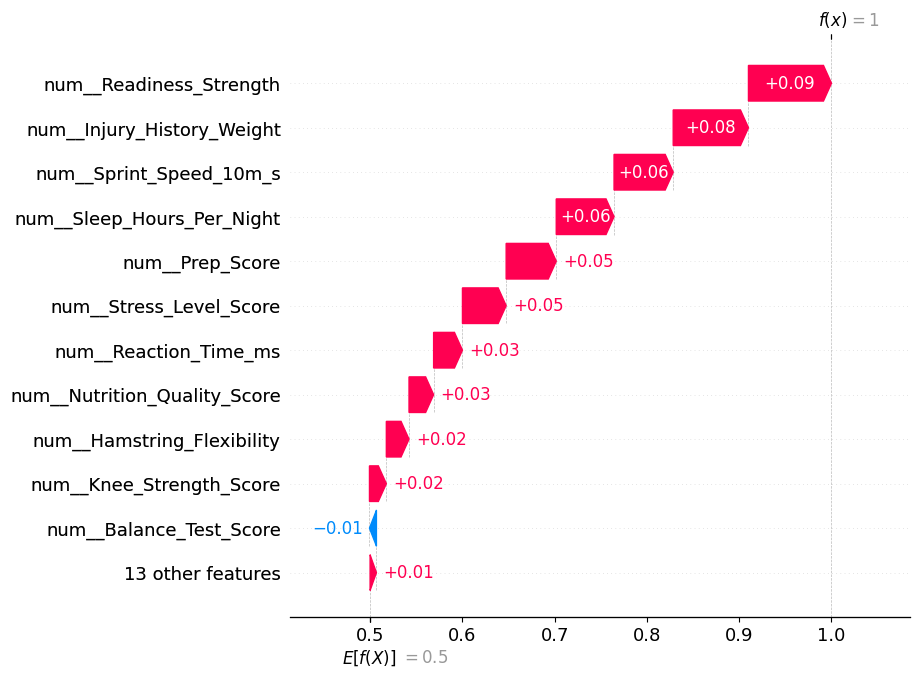

<Figure size 640x480 with 0 Axes>

Saved waterfall to: ../artifacts/shap_waterfall_highest_risk_sample.png


In [130]:
# --- A: Waterfall for the highest-risk real sample ---
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, joblib
OUT_DIR = "../artifacts"
os.makedirs(OUT_DIR, exist_ok=True)
WATER_PATH = os.path.join(OUT_DIR, "shap_waterfall_highest_risk_sample.png")

# 1) ensure y_proba exists (run model.predict_proba(X_test) earlier)
if 'y_proba' not in globals():
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except Exception:
        # try pipeline end-to-end on raw X_test
        y_proba = model.predict_proba(X_test)[:, 1]

# 2) choose sample index (highest predicted probability)
sample_idx = int(np.argmax(y_proba))
print("Selected sample index:", sample_idx)

# 3) ensure we have shap_values_raw or explainer
if 'shap_values_raw' not in globals():
    # try to compute shap values (use explainer if available)
    try:
        explainer = shap.Explainer(model, X_test)   # shap will choose the right explainer
        shap_values_raw = explainer(X_test)
    except Exception as e:
        raise RuntimeError("No existing shap_values_raw and failed to compute explainer: " + str(e))

# 4) normalize/extract class-1 shap values robustly
arr = np.asarray(shap_values_raw)
n_samples = X_test_trans.shape[0]
n_features_out = X_test_trans.shape[1]
if arr.ndim == 3 and arr.shape[0] == n_samples and arr.shape[1] == n_features_out and arr.shape[2] >= 2:
    vals = arr[..., 1]
elif hasattr(shap_values_raw, 'values') and np.asarray(shap_values_raw.values).ndim == 3:
    vals = np.asarray(shap_values_raw.values)[..., 1]
else:
    # fallback if shap.Explainer returned a 2d matrix already
    vals = np.asarray(shap_values_raw)
if vals.shape != (n_samples, n_features_out):
    raise RuntimeError(f"After slicing, vals.shape={vals.shape} expected {(n_samples,n_features_out)}")

# 5) get feature names
feature_names_final = None
try:
    if 'preprocessor_fitted' in globals() and hasattr(preprocessor_fitted, "get_feature_names_out"):
        try:
            feature_names_final = list(preprocessor_fitted.get_feature_names_out(X.columns))
        except Exception:
            feature_names_final = list(preprocessor_fitted.get_feature_names_out())
except Exception:
    feature_names_final = None
if feature_names_final is None or len(feature_names_final) != n_features_out:
    feature_names_final = [f"f_{i}" for i in range(n_features_out)]

# 6) plot waterfall (legacy) for chosen sample
plt.figure(figsize=(10,5))
try:
    # shap_values_raw might be the object from explainer; try to access class 1
    try:
        shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values_raw[...,1][sample_idx],
                                               feature_names=feature_names_final, max_display=12)
    except Exception:
        # fallback to using vals
        shap.plots._waterfall.waterfall_legacy(explainer.expected_value, vals[sample_idx],
                                               feature_names=feature_names_final, max_display=12)
except Exception:
    # final fallback: barh of top contributions
    single_shap = np.asarray(vals[sample_idx])
    topk = np.argsort(np.abs(single_shap))[::-1][:12]
    contrib_df = pd.DataFrame({"feature":[feature_names_final[i] for i in topk],"shap":single_shap[topk]}).sort_values("shap")
    contrib_df.plot.barh(x="feature", y="shap", legend=False, figsize=(8,4))

plt.tight_layout()
plt.savefig(WATER_PATH, dpi=150)
plt.show()
print("Saved waterfall to:", WATER_PATH)


## 15. Model Interpretation & Applied Insights (SHAP Analysis)

This final section connects the Random Forest predictions to domain-specific meaning using SHAP.  
By examining global patterns, feature-specific interactions, and individual risk explanations, we can understand *why* the model behaves as it does — and how to translate this into actionable recommendations for athlete performance and injury prevention.

---

### 15.1 Global SHAP Insights

The SHAP summary plot reveals a clear hierarchy of risk factors:

1. **Readiness_Strength**  
   - The strongest and most consistent contributor.  
   - Lower readiness (poor balance, flexibility, or knee strength) greatly increases injury risk.  
   - High readiness substantially reduces predicted risk.

2. **Injury_History_Weight**  
   - Past injuries, combined with stress levels, strongly drive vulnerability.  
   - Players with recurrent injury patterns maintain elevated baseline risk even when other metrics are stable.

3. **Reaction_Time_ms**, **Sleep_Hours_Per_Night**, and **Sprint_Speed_10m_s**  
   - SHAP shows that slower reaction time and reduced sleep increase predicted injury probability.  
   - Faster sprint capability appears protective when paired with adequate recovery.

4. **Prep_Score** and **Stress_Level_Score**  
   - Behavioral factors (warmup quality, nutrition, sleep hygiene) meaningfully influence risk.  
   - Elevated stress amplifies the effect of other negative factors.

5. **Workload & Exposure Metrics**  
   - Training hours and matches played matter, but less than neuromuscular readiness and past injuries.  
   - This aligns with literature showing that *load alone* is rarely sufficient to explain injury — but load *combined with readiness deficits* is much more predictive.

These results validate the engineered features from Notebook 02 and align with performance science findings: **injury risk is multifactorial**, driven by biomechanical readiness, recovery quality, historical vulnerability, and training exposure.

---

### 15.2 Feature-Specific Interpretation (Dependence Analysis)

The dependence plot for **Readiness_Strength** shows a **strong negative linear trend**:

- High readiness → negative SHAP values → lower predicted injury risk  
- Low readiness → positive SHAP values → higher predicted risk

This demonstrates that even small declines in neuromuscular readiness (balance, strength, flexibility) significantly increase risk — a pattern well documented in sports medicine.

The clear slope suggests the model is highly sensitive to this feature, making it an excellent candidate for continuous monitoring.

---

### 15.3 Local Interpretability (Individual Athlete Risk Profile)

The SHAP waterfall plot illustrates how a single player’s risk is constructed:

- **Readiness_Strength**, **Injury_History_Weight**, and **Sprint_Speed_10m_s** drive the risk upward for this specific athlete.
- **Prep_Score**, **Sleep_Hours_Per_Night**, and **Hamstring_Flexibility** mitigate risk by pulling the prediction downward.
- Minor contributions from secondary features (BMI, weekly workload, height/weight) accumulate but remain less impactful.

This individualized view is essential for real-world application:  
coaches and performance staff can understand *exactly why* a player is flagged and what targeted interventions could reduce risk.

---

### 15.4 Practical Recommendations for Performance & Medical Staff

Based on the interpretability findings, three evidence-based intervention areas emerge:

#### **1. Neuromuscular Readiness (Highest Priority)**  
- Strengthen knee stability, balance, and hamstring flexibility.  
- Include eccentric strength blocks, stability circuits, and proprioceptive training.  
- Implement readiness assessments at least 2–3× per week.

#### **2. Load Management & Recovery Monitoring**  
- Track Training Hours and Match Exposure to avoid acute spikes.  
- Adjust load for players with high Injury_History_Weight.  
- Add post-match fatigue monitoring (reaction time, subjective wellness, HRV if available).

#### **3. Behavioral Preparation & Lifestyle Factors**  
- Improve warmup routine adherence.  
- Reinforce sleep hygiene protocols.  
- Ensure consistency in nutrition (especially pre-training and post-match).  
- Target stress reduction strategies (breathing work, recovery blocks, psychological support).

These interventions are fully aligned with the SHAP signals and represent the actionable pathway for reducing risk in practice.

---

### 15.5 Final Remarks

With the interpretability step complete, the project now provides:

- A clean and transparent **injury risk prediction pipeline**  
- Strong engineered features grounded in domain knowledge  
- A robust **Random Forest model** supported by high recall and solid generalization  
- A full SHAP-based interpretability layer  
- Practical insights applicable to athlete management, injury prevention, and performance optimization